 ## New simulations: Single trial type

Here I'm revamping my previous simulation for a model with a single trial type. Analogously, this could be a design with multiple trial types where you're only looking at contrasts of task vs baseline. I added more variety and changed how the bold data were simulated, which helped me understand the previous contradictory results.  Also, for the group comparisions I run with and without an adjustment for subject-specific mean RT.

Recapping why I was surprised by the last set of simuations, I had previously seen increased Type I error in group comparisons of the parameter associated with the unmodulated regressor, but in those simulations I only found it in the RT-modulated regressor where the mean RT (within-subject) was used as the duration.  The reason I didn't find increased Type I error with the unmodulated regressor is related to how the data were simulated.  I used a combination of modulated and unmodulated regressors to make the BOLD data, but I believe it is more realistic to either assume the duration is the RT (scales with RT) or the duration is some other unknown constant that we will assume is the same across subjects (doesn't scale with RT), but hope the model is flexible enough to capture either scenario.  That is how these simulations are designed.  As for the finding where the RT modulated regressors showed increased error rates for the group comparison, this is due to the mean RT being used as the duration, which you will see is generally problematic.  Actually, no matter what, we should be adjusting for mean RT in our group models.  I see no way to remove this variability at the first level.  As it is a between-subject difference, I don't see how it could be removed without knowledge of the other subject's activation magnitudes, if that makes sense.

As I said above, in these simulations I stick to the true BOLD signal either scaling with RT or not.  What I mean by scaling is that the duration of the stimulus is the RT.  When it is not, I use a delta function convolved with the HRF to generate the BOLD signal (equivalent to a stimulus of length 1/16 s).  

The other big difference is I looked at a wider variety of models. Aside from a model with just a single regressor where the duration is set to the RT and modulation values are all 1, the other 6 models include two regressors.  The single regressor model is my "reality check" model, since that's what is used to simulate the data in the scales with RT scenario.  In most cases I match what is used for the duration for both regressors.  I think the labeling system is more transparent here.  For example, in the plots and Type I error output, the "est_dur_2_both_unmod" refers to a model where both regressors had a duration of 2s (dur_2_both) and this is specifically the unmodulated regressor of that pair.  Then est_dur_2_both_rtmod is the second regressor in that same model, but has a modulation of mean centered RT (RT is always mean centered when added as a modulation).  On the other hand, est_dur_2_0_unmod and est_dur_2_0_rtmod are the two regressors (unmodulated and modulate by mean centered RT) where the durations don't match.  The duration is 2 for the unmodulated regressor and 0 for the modulated regressor.  All-in-all there are 8 models with a total of 15 contrast estimates (unmodulated/modulated for the 7 models with 2 regresors and the one RT regressor in reality check model).

The other difference worth mentioning is in how I simulated the RTs.  Previously I think I simulated them for all trials and subjects from the same distribution, with the same mean.  That's not realistic either.  Here I estimate RT hierarchically and I'm not using the exgaussian distribution.  First I sample one value for each subject, which serves as the mu parameter of the exgaussian (after subtracting 1/lambda = 100).  Then I sample the RTs for each subject using their specific value of mu.  This then allows us to look at how the subjects' parameter estimates correlate (or don't) with their mean RT values.  If the hierarchical simulation isn't used there won't be any between-subject variance in RT.  Sometimes the simulated values fell out of the 0-2000 range, where 2s is the length of the stimulus presentation.  When this happened I set negative values to 50ms and those above 2000ms to 1500s.  At one point I had an error message that would display when this occurred and it was fairly rare, so I've suspended that error.  If you change the rt values, keep this in mind.  In the near future I will output the RTs as well so they can be double-checked.

First, I need a function for generating regressors.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from nistats import hemodynamic_models
import statsmodels.api as sm
from scipy.stats import t
from scipy.stats import exponnorm
import pandas as pd
import seaborn as sns

def make_des_one_trial_type(rt_mu1, n_trials):
    # rt_mu1: Mean RT parameter mu (note, actual mean is mu - 100 since I'm 
    #  using the exponnorm function)
    # n_trial: number of trials.  
    # lam, mu and sigma follow wiki definitions and I translated to parameters used in python
    lam = 1/100
    sigma = 75
    k = 1/(sigma * lam)

    # theoretical mean = rt_mu + 1/lam
    # theoretical variance = sigma**2 + 1/lam**2
    # gleaned from fig 1 of "Analysis of response time data (heathcote)
    # mus: 600-700, sigma: 50-100, lam = 1/tau..tau: 100

    # Estimate RTs hierarchically.  Using same distribution 
    # for both levels, maybe that's not correct... 
    # Within and between-subject variances aren't likely equal...
    # Not sure if this is "correct".  I'm using this as the mu parameter
    # when I sample the RTs over the run, so I'm subtracting 1/lam
    # from a single sample. Might change this later
    #  
    rt_lev1_mu = exponnorm.rvs(k, rt_mu1, sigma, 1) - 1/lam 
    rt_trials = exponnorm.rvs(k, rt_lev1_mu, sigma, n_trials)

    #rt_lev1_mu = np.random.uniform(rt_mu1 - 200, rt_mu1 + 200, 1)
    #rt_trials = np.random.uniform(rt_lev1_mu - 150, rt_lev1_mu + 150, n_trials)
    rt_trial_mn = np.mean(rt_trials)
    rt_trials_mc = (rt_trials - rt_trial_mn)/1000
    
    # Should be rare (if parameter are chosen well)
    # if RT falls outside of 0-2000, set to 500/1950
    if np.amax(rt_trials) > 2000: 
        rt_trials[rt_trials>2000] = 1950
    
    if np.amin(rt_trials) < 0:
        rt_trials[rt_trials<0] = 500
    #   print("WARNING: RTs too long or too short")
    #    print("min RT is {} max RT is {}".format(np.amin(rt_trials),  np.amax(rt_trials)))
        
    # onset times.  Assume 2s for stimulus and 3s for ISI.  Using same onsets
    # for when duration =1 and duration = RT (duration of stimulus presentation)
    # Obviously there will be a problem if the RT is longer than 2s, but the above will
    # help avoid this.
    onsets = 5 + 5*np.arange(0, 40)
        
    # 7 regressors total.
    # One with duration = RT/modulation = 1
    # Three unmodulated (duration = 0, 2, meanRT)
    # Three modulated (duration = 0, 2, meanRT) (modulation = mcRT in all cases)
    frame_times = np.arange(0, 220, 1)
    dur_0 = np.zeros(onsets.shape)
    dur_2 = dur_0 + 2
    dur_mnrt = dur_0 + rt_trial_mn/1000

    unmod_vals = np.ones(onsets.shape)

    # Unmodulated
    dur_2_mod1_3col = np.transpose(np.c_[onsets, dur_2, unmod_vals])
    dur_2_mod1, name = hemodynamic_models.compute_regressor(dur_2_mod1_3col, 'spm', frame_times, oversampling = 16)

    dur_0_mod1_3col = np.transpose(np.c_[onsets, dur_0, unmod_vals])
    dur_0_mod1, name = hemodynamic_models.compute_regressor(dur_0_mod1_3col, 'spm', frame_times, oversampling = 16)

    dur_mnrt_mod1_3col = np.transpose(np.c_[onsets, dur_mnrt, unmod_vals])
    dur_mnrt_mod1, name = hemodynamic_models.compute_regressor(dur_mnrt_mod1_3col, 'spm', frame_times, oversampling = 16)

    # Modulated
    dur_2_mod_mcrt_3col = np.transpose(np.c_[onsets, dur_2, rt_trials_mc])
    dur_2_mod_mcrt, name = hemodynamic_models.compute_regressor(dur_2_mod_mcrt_3col, 'spm', frame_times, oversampling = 16)

    dur_0_mod_mcrt_3col = np.transpose(np.c_[onsets, dur_0, rt_trials_mc])
    dur_0_mod_mcrt, name = hemodynamic_models.compute_regressor(dur_0_mod_mcrt_3col, 'spm', frame_times, oversampling = 16)

    dur_mnrt_mod_mcrt_3col = np.transpose(np.c_[onsets, dur_mnrt, rt_trials_mc])
    dur_mnrt_mod_mcrt, name = hemodynamic_models.compute_regressor(dur_mnrt_mod_mcrt_3col, 'spm', frame_times, oversampling = 16)

    # Duration = RT, unmodulated
    dur_rt_mod_1_3col = np.transpose(np.c_[onsets, rt_trials/1000, unmod_vals])
    dur_rt_mod_1, name = hemodynamic_models.compute_regressor(dur_rt_mod_1_3col, 'spm', frame_times, oversampling = 16)
    return dur_2_mod1, dur_0_mod1, dur_mnrt_mod1, dur_2_mod_mcrt, dur_0_mod_mcrt, \
        dur_mnrt_mod_mcrt, dur_rt_mod_1, rt_trial_mn

<ipython-input-1-b8789ae99c55>:3: FutureWarning: 

 | Starting with Nilearn 0.7.0, all Nistats functionality has been incorporated into Nilearn's stats & reporting modules.
 | Nistats package will no longer be updated or maintained.

  from nistats import hemodynamic_models


Functions for running regression and running simulation for 1 data set and estimating the 8 models.

In [2]:
def runreg(y, x, contrast):
    inv_xt_x = np.linalg.inv(x.T.dot(x))
    beta_hat = inv_xt_x.dot(x.T).dot(y)
    residual = y - x.dot(beta_hat)
    df = x.shape[0] - x.shape[1]
    sigma = np.sqrt(sum(residual**2)/df)
    con_est = contrast.dot(beta_hat)
    con_t = con_est/(np.sqrt(contrast.dot(inv_xt_x).dot(contrast.T))*sigma)
    con_p = t.sf(abs(con_t), df)*2
    return con_est, con_t, con_p

In [3]:
def run_sim_1trial_type(scales, beta_1, beta_2, noise_sd, rt_g1, rt_g2, nsub_grp):
    # scales: 1 = yes (bold = 1 + beta*dur_rt_mod_1 + noise), 
    #          0= no  (bold = 1 + beta*dur_0_mod1 + noise)
    # beta_1, beta_2: Parameter used to generate bold data for groups 1 and 2 (see above)
    # noise_sd:  Standard deviation for gaussian noise generated to make bold data
    # rt_g1/rt_g2:  mu for rt distribution for each group (note using ex-gauss, so mu isn't mean)
    # nsub_grp:  How many subjects in each group?
    #
    nsub = 2*nsub_grp
    n_trials = 40

    rt_vec_all = np.repeat([rt_g1, rt_g2], nsub_grp)
    beta_all = np.repeat([beta_1, beta_2], nsub_grp)
    grp_ind = np.repeat([0,1], nsub_grp)

    mn_rt_all = np.empty([nsub, 1])
    est_all = np.empty([nsub, 15])

    for i in range(0, nsub):
        dur_2_mod1, dur_0_mod1, dur_mnrt_mod1, dur_2_mod_mcrt, dur_0_mod_mcrt, \
            dur_mnrt_mod_mcrt, dur_rt_mod_1, rt_trial_mn = make_des_one_trial_type(rt_vec_all[i], n_trials)
        mn_rt_all[i] = rt_trial_mn
        n_tr = len(dur_0_mod1)
        if scales == 1:
            bold = 1 + beta_all[i]*dur_rt_mod_1 + np.random.normal(0, noise_sd, size = [n_tr,1])
        if scales == 0:
            bold = 1 + beta_all[i]*dur_0_mod1 + np.random.normal(0, noise_sd, size = [n_tr,1])
        # estimate 8 models, 1 contrast for 1 and 2 for the rest (15 contrast estimates)
        # Reality check model
        des_dur_rt = sm.add_constant(dur_rt_mod_1)
        est_dur_rt, con_t, con_p = runreg(bold, des_dur_rt, np.array([0,1]))
        est_all[i, 0] = est_dur_rt
        # Duration =2s, unmod and mod mc_rt model
        des_dur_2_both = sm.add_constant(np.c_[dur_2_mod1, dur_2_mod_mcrt])
        est_dur_2_both_unmod, con_t, con_p = runreg(bold, des_dur_2_both, np.array([0,1, 0]))
        est_dur_2_both_rtmod, con_t, con_p = runreg(bold, des_dur_2_both, np.array([0,0,1]))
        est_all[i, 1] = est_dur_2_both_unmod
        est_all[i,2] = est_dur_2_both_rtmod
        # Duration =0s, unmod and mod mc_rt model
        des_dur_0_both = sm.add_constant(np.c_[dur_0_mod1, dur_0_mod_mcrt])
        est_dur_0_both_unmod, con_t, con_p = runreg(bold, des_dur_0_both, np.array([0,1, 0]))
        est_dur_0_both_rtmod, con_t, con_p = runreg(bold, des_dur_0_both, np.array([0,0,1]))
        est_all[i,3] = est_dur_0_both_unmod
        est_all[i,4] = est_dur_0_both_rtmod
        # Duration = mnrt, unmod and mod mc_rt model
        des_dur_mnrt_both = sm.add_constant(np.c_[dur_mnrt_mod1, dur_mnrt_mod_mcrt])
        est_dur_mnrt_both_unmod, con_t, con_p = runreg(bold, des_dur_mnrt_both, np.array([0,1, 0]))
        est_dur_mnrt_both_rtmod, con_t, con_p = runreg(bold, des_dur_mnrt_both, np.array([0,0,1]))
        est_all[i,5] = est_dur_mnrt_both_unmod
        est_all[i, 6] = est_dur_mnrt_both_rtmod

        # Duration = mnrt/unmod and dur= 0/ mod mc_rt model
        des_dur_mnrt_0 = sm.add_constant(np.c_[dur_mnrt_mod1, dur_0_mod_mcrt])
        est_dur_mnrt_0_unmod, con_t, con_p = runreg(bold, des_dur_mnrt_0, np.array([0,1, 0]))
        est_dur_mnrt_0_rtmod, con_t, con_p = runreg(bold, des_dur_mnrt_0, np.array([0,0,1]))
        est_all[i,7] = est_dur_mnrt_0_unmod
        est_all[i, 8] = est_dur_mnrt_0_rtmod


        # Duration = 2/unmod dur = mnrt/mod mc_rt model
        des_dur_2_mnrt = sm.add_constant(np.c_[dur_2_mod1, dur_mnrt_mod_mcrt])
        est_dur_2_mnrt_unmod, con_t, con_p = runreg(bold, des_dur_2_mnrt, np.array([0,1, 0]))
        est_dur_2_mnrt_rtmod, con_t, con_p = runreg(bold, des_dur_2_mnrt, np.array([0,0,1]))
        est_all[i, 9] = est_dur_2_mnrt_unmod
        est_all[i,10] = est_dur_2_mnrt_rtmod
        # Duration = 2/unmod dur = 0/mod mc_rt model
        des_dur_2_0 = sm.add_constant(np.c_[dur_2_mod1, dur_0_mod_mcrt])
        est_dur_2_0_unmod, con_t, con_p = runreg(bold, des_dur_2_0, np.array([0,1, 0]))
        est_dur_2_0_rtmod, con_t, con_p = runreg(bold, des_dur_2_0, np.array([0,0,1]))
        est_all[i, 11] = est_dur_2_0_unmod
        est_all[i,12] = est_dur_2_0_rtmod
        # Duration = 0/unmod dur = mnrt/mod mc_rt model
        des_dur_0_mnrt = sm.add_constant(np.c_[dur_0_mod1, dur_mnrt_mod_mcrt])
        est_dur_0_mnrt_unmod, con_t, con_p = runreg(bold, des_dur_0_mnrt, np.array([0,1, 0]))
        est_dur_0_mnrt_rtmod, con_t, con_p = runreg(bold, des_dur_0_mnrt, np.array([0,0,1]))
        est_all[i, 13] = est_dur_0_mnrt_unmod
        est_all[i, 14] = est_dur_0_mnrt_rtmod

    # Also, I probably should have used pandas sooner?  Oh well, next time!!
    # This will have to do for now.
    col_names = ["est_dur__rt", "est_dur_2_both__unmod", "est_dur_2_both__rtmod",\
        "est_dur_0_both__unmod", "est_dur_0_both__rtmod",  "est_dur_mnrt_both__unmod", \
        "est_dur_mnrt_both__rtmod", "est_dur_mnrt_0__unmod", "est_dur_mnrt_0__rtmod", \
        "est_dur_2_mnrt__unmod", "est_dur_2_mnrt__rtmod",\
        "est_dur_2_0__unmod", "est_dur_2_0__rtmod", "est_dur_0_mnrt__unmod", \
        "est_dur_0_mnrt__rtmod" ]

    # Run 2-sample t-test to compare groups (level 2 analysis)
    des2samp = sm.add_constant(grp_ind)
    con_est, con_t, pval = runreg(est_all, des2samp, np.array([0,1]))

    pval_pd = pd.DataFrame(data = np.c_[pval].T, columns = col_names)

    # Also run 2-sample t-test with adjustment for mean RT
    des2samp_adj = sm.add_constant(np.c_[grp_ind, mn_rt_all])
    con_est_adj, con_t_adj, pval_adj_mnrt = runreg(est_all, des2samp_adj, np.array([0,1,0]))

    pval_adj_mnrt_pd = pd.DataFrame(data = np.c_[pval_adj_mnrt].T, columns = col_names)

    # Correlate subject estimates with mean RT within-subject for each contrast
    cor_w_rt = np.corrcoef(np.c_[mn_rt_all,est_all].T)
    cor_out = cor_w_rt[0, 1:16]
    cor_w_rt_pd = pd.DataFrame(data = np.c_[cor_out].T, columns = col_names)
    return pval_pd, pval_adj_mnrt_pd, cor_w_rt_pd



Function that runs a set of simulations and summarizes the results.  Choose dramatic beta/noise values so you can get the idea with fewer simulations.  Although two betas are specified, beta_1 is used for both groups for assessing Type I error, while the specified beta_1/beta_2 are used for power. Each one takes a bit of time to run, which is why I only ran 100 simulations for each, so do not overinterpret the error rates/power.  The summary will show the type I error rates, power and boxplots illustrating the distribution of correlations between the subject-specific parameter estimates and the subject-specific mean RT values.    

In [4]:
def run_and_summarize_1trial_type(nsim, scales, beta_1, beta_2, noise_sd, rt_g1, rt_g2, nsub_grp):
    pval_all_t1 = np.empty([nsim, 15])
    pval_all_adj_mnrt_t1 = np.empty([nsim, 15])
    cor_w_rt_all_t1 = np.empty([nsim, 15])
    pval_all_pow = np.empty([nsim, 15])
    pval_all_adj_mnrt_pow = np.empty([nsim, 15])
    cor_w_rt_all_pow = np.empty([nsim, 15])

    for i in range(0, nsim):
        # Use beta_1 for both to calculate type I error
        pvals, pvals_adj_mnrt, cor_w_rt = run_sim_1trial_type(scales, beta_1, beta_1, noise_sd, rt_g1, rt_g2, nsub_grp)
        pval_all_t1[i,:] = pvals
        pval_all_adj_mnrt_t1[i,:] = pvals_adj_mnrt
        cor_w_rt_all_t1[i,:] = cor_w_rt

        # Now power
        pvals, pvals_adj_mnrt, cor_w_rt = run_sim_1trial_type(scales, beta_1, beta_2, noise_sd, rt_g1, rt_g2, nsub_grp)
        pval_all_pow[i,:] = pvals
        pval_all_adj_mnrt_pow[i,:] = pvals_adj_mnrt
        cor_w_rt_all_pow[i,:] = cor_w_rt
        # I use this below
        col_names = pvals.columns
    
    # Unadjusted for RT
    # Type I error rates
    sig_all_t1 = 1*pval_all_t1 < 0.05
    sig_all_t1_pd = pd.DataFrame(data = sig_all_t1, columns = col_names)
    t1_err = sig_all_t1_pd.mean(axis = 0)
    # Power
    sig_all_pow = 1*pval_all_pow < 0.05
    sig_all_pow_pd = pd.DataFrame(data = sig_all_pow, columns = col_names)
    pow_est = sig_all_pow_pd.mean(axis = 0)
    # Put them together
    type1_and_pow = pd.concat([t1_err, pow_est], axis = 1)
    type1_and_pow.columns = ["Type I error", "Power"]
    print("Two sample t-test, unadjusted for mean RT")
    print("Only interpret power if Type I error is controlled")
    print(type1_and_pow)
 
    # Adjusted for RT
    # Type I error rates
    sig_all_t1_adj = 1*pval_all_adj_mnrt_t1 < 0.05
    sig_all_t1_adj_pd = pd.DataFrame(data = sig_all_t1_adj, columns = col_names)
    t1_err_adj = sig_all_t1_adj_pd.mean(axis = 0)
    # Power
    sig_all_pow_adj = 1*pval_all_adj_mnrt_pow < 0.05
    sig_all_pow_adj_pd = pd.DataFrame(data = sig_all_pow_adj, columns = col_names)
    pow_est_adj = sig_all_pow_adj_pd.mean(axis = 0)
    # Put them together
    type1_and_pow_adj = pd.concat([t1_err_adj, pow_est_adj], axis = 1)
    type1_and_pow_adj.columns = ["Type I error", "Power"]
    print("")
    print("Two sample t-test, ADJUSTED for mean RT")
    print("Only interpret power if Type I error is controlled")
    print(type1_and_pow_adj)

    # Correlations (Null, unadjusted)
    cor_w_rt_all_pd = pd.DataFrame(data = cor_w_rt_all_t1, columns = col_names)
    cor_w_rt_all_pd_long = pd.melt(cor_w_rt_all_pd, value_name = "Correlation")
    cor_w_rt_all_pd_long[['model', 'variable']] = cor_w_rt_all_pd_long.variable.str.split("__", expand = True)
    
    sns.boxplot(y = 'model', x = 'Correlation', data = cor_w_rt_all_pd_long, hue = 'variable').set_title("Correlation between contrast estimate and mean RT (null data)")
    

### No group difference in RT when signal scales with RT

Below you will see the error rates seems fine but don't over interpret since the number of simulations is a bit low.  No big differences with or without adjustment for RT for Type I error or Power.  Keep in mind this how many simulations I ran.  Unless it is 1000, I wouldn't compare much between type I error/power estimates.  I figured this was enough to see the gross problems.  

You can see the RT effects are present at the group level for most parameters, but since RT didn't differ by group it didn't inflate the Type I errors.  Less so for the modulated rt regressors, but almost always for the unmodulated regressors.  The exception seems to be the unmodulated regressor with a duration of the mean RT.  The positive correlations make sense to me, but when the duration is set to the mean RT the correlations tend to be negative and I don't fully understand why (yet).  I'll summarize from the top to the bottom of the figure.  At the very top is the reality check model and it should be fine.  The next two boxes are for the model where the duration was set to 2 for both the unmodulated and modulated regressors.  The RT correlation is worse for the unmodulated regressor and is seemingly okay for the RT-modulated regressor.  Similar story when the duration is 0 (next 2 boxplots).  Using the mean RT as the duration the unmodulated regressor seems okay (more testing needed) but now the modulated regressor is in trouble.  I need to give it more though why the correlation here is negative.  The next pair of models have different durations, where the unmodulated regressor has a 2s duration and the modulated regressor has a mean RT duration and both are correlated with RT, but in different directions!  Again, I'll need to think more about why this is the case.  Similar patterns occur when the durations are not matched in the distributions below that.  Things seems slightly better for the RT regressor when the duration is not set to the mean RT.

Two sample t-test, unadjusted for mean RT
Only interpret power if Type I error is controlled
                          Type I error  Power
est_dur__rt                       0.06   0.65
est_dur_2_both__unmod             0.07   0.51
est_dur_2_both__rtmod             0.06   0.24
est_dur_0_both__unmod             0.06   0.52
est_dur_0_both__rtmod             0.09   0.31
est_dur_mnrt_both__unmod          0.10   0.53
est_dur_mnrt_both__rtmod          0.05   0.24
est_dur_mnrt_0__unmod             0.10   0.53
est_dur_mnrt_0__rtmod             0.09   0.31
est_dur_2_mnrt__unmod             0.07   0.52
est_dur_2_mnrt__rtmod             0.06   0.24
est_dur_2_0__unmod                0.07   0.52
est_dur_2_0__rtmod                0.08   0.31
est_dur_0_mnrt__unmod             0.06   0.52
est_dur_0_mnrt__rtmod             0.05   0.23

Two sample t-test, ADJUSTED for mean RT
Only interpret power if Type I error is controlled
                          Type I error  Power
est_dur__rt                      

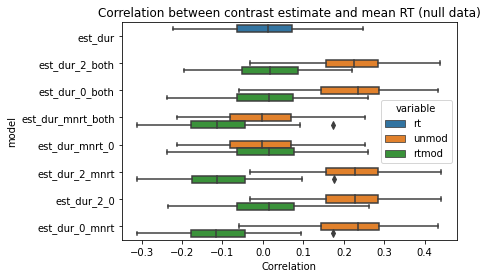

In [5]:
scales = 1
beta_1 = 1
beta_2 = 1.5 # beta_2 is set to beta_1 for type I error calculation, but used in power
noise_sd = .5
rt_g1 = 400
rt_g2 = 400
nsub_grp = 40
nsim = 100

run_and_summarize_1trial_type(nsim, scales, beta_1, beta_2, noise_sd, rt_g1, rt_g2, nsub_grp)

### No group difference in RT when signal doesn't scale with RT

Same as above, but without the scaling. Starting with Type I error, all is well both adjusted and unadjusted for RT.  The power should be really low (5%) for the modulated RT regressors, since there isn't an RT effect.  The correlations all seem to be mostly centered about 0.  Wow, that legend placement is really great :(

Two sample t-test, unadjusted for mean RT
Only interpret power if Type I error is controlled
                          Type I error  Power
est_dur__rt                       0.05   0.72
est_dur_2_both__unmod             0.05   0.80
est_dur_2_both__rtmod             0.04   0.03
est_dur_0_both__unmod             0.04   0.82
est_dur_0_both__rtmod             0.05   0.03
est_dur_mnrt_both__unmod          0.06   0.81
est_dur_mnrt_both__rtmod          0.06   0.06
est_dur_mnrt_0__unmod             0.06   0.81
est_dur_mnrt_0__rtmod             0.05   0.03
est_dur_2_mnrt__unmod             0.07   0.82
est_dur_2_mnrt__rtmod             0.06   0.06
est_dur_2_0__unmod                0.07   0.82
est_dur_2_0__rtmod                0.05   0.03
est_dur_0_mnrt__unmod             0.04   0.82
est_dur_0_mnrt__rtmod             0.06   0.06

Two sample t-test, ADJUSTED for mean RT
Only interpret power if Type I error is controlled
                          Type I error  Power
est_dur__rt                      

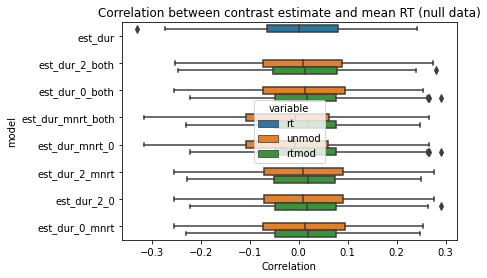

In [6]:
scales = 0
beta_1 = 1
beta_2 = 6.5 # had to make betas more different when scales = 0 (remember dur0 regressor is used to generate data)
noise_sd = .5
rt_g1 = 400
rt_g2 = 400
nsub_grp = 40
nsim = 100
run_and_summarize_1trial_type(nsim, scales, beta_1, beta_2, noise_sd, rt_g1, rt_g2, nsub_grp)

### Group difference in RT when signal scales with RT

Below you'll see inflated error rates for the group difference for the unmodulated regressors, in general, as well as regressors where the duration is set to the mean RT.  Things improve when the group comparison is adjusted for subject-specific mean RT.  The only case when the unmodulated regressor seems okay, in terms of the correlation with RT and Type I error, is when the duration is the mean RT, but the RT-modulated regressor fails in that model unless duration for the RT-modulated regressor is set to 0.  Personally, I'd prefer keeping the durations set equal for both regressors if possible.  Maybe there's no good reason for doing this though?   Maybe that's some magic combination that can remove between-subject RT differences in level 1?  I'll need to think on that more.  I'd say the answer to that is no, since adding mean RT to the group model impacts the power for that model.

Two sample t-test, unadjusted for mean RT
Only interpret power if Type I error is controlled
                          Type I error  Power
est_dur__rt                       0.05   0.84
est_dur_2_both__unmod             0.35   1.00
est_dur_2_both__rtmod             0.05   0.21
est_dur_0_both__unmod             0.32   0.99
est_dur_0_both__rtmod             0.05   0.22
est_dur_mnrt_both__unmod          0.05   0.59
est_dur_mnrt_both__rtmod          0.14   0.02
est_dur_mnrt_0__unmod             0.05   0.59
est_dur_mnrt_0__rtmod             0.05   0.22
est_dur_2_mnrt__unmod             0.36   0.99
est_dur_2_mnrt__rtmod             0.14   0.02
est_dur_2_0__unmod                0.36   0.99
est_dur_2_0__rtmod                0.05   0.23
est_dur_0_mnrt__unmod             0.32   0.99
est_dur_0_mnrt__rtmod             0.14   0.02

Two sample t-test, ADJUSTED for mean RT
Only interpret power if Type I error is controlled
                          Type I error  Power
est_dur__rt                      

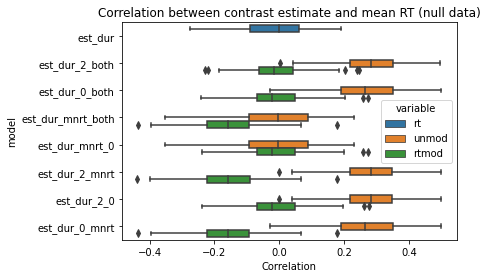

In [7]:
scales = 1
beta_1 = 1
beta_2 = 1.5
noise_sd = .5
rt_g1 = 400
rt_g2 = 600
nsub_grp = 40
nsim = 100 

run_and_summarize_1trial_type(nsim, scales, beta_1, beta_2, noise_sd, rt_g1, rt_g2, nsub_grp)

### Group difference in RT when signal doesn't scale with RT

Below you can see the type I errors, as expected, are fine.  Of course there's still the issue where mean RT correlations are present at the group level, no matter what.  This seems worse when the duration of regressors is set to the mean RT value.  No large power differences.  Both the dur_2_both and dur_0_both models perform well.  Recall the dur_0_unmod regressor was used to generate the true data.

It seems the correlations shift from 0 when the duration is set to the mean RT.  Not a huge effect, but it seems to be present.  Of course if it is very large it will be reflected in the error rate as well.


Two sample t-test, unadjusted for mean RT
Only interpret power if Type I error is controlled
                          Type I error  Power
est_dur__rt                       0.03   0.57
est_dur_2_both__unmod             0.03   0.69
est_dur_2_both__rtmod             0.04   0.09
est_dur_0_both__unmod             0.02   0.81
est_dur_0_both__rtmod             0.05   0.09
est_dur_mnrt_both__unmod          0.02   0.57
est_dur_mnrt_both__rtmod          0.04   0.08
est_dur_mnrt_0__unmod             0.02   0.57
est_dur_mnrt_0__rtmod             0.05   0.09
est_dur_2_mnrt__unmod             0.03   0.70
est_dur_2_mnrt__rtmod             0.04   0.08
est_dur_2_0__unmod                0.03   0.71
est_dur_2_0__rtmod                0.05   0.09
est_dur_0_mnrt__unmod             0.01   0.81
est_dur_0_mnrt__rtmod             0.04   0.08

Two sample t-test, ADJUSTED for mean RT
Only interpret power if Type I error is controlled
                          Type I error  Power
est_dur__rt                      

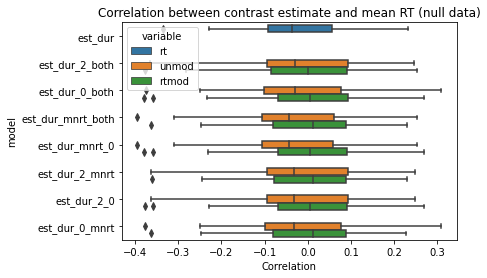

In [8]:
scales = 0
beta_1 = 1
beta_2 = 6.5
noise_sd = .5
rt_g1 = 400
rt_g2 = 600
nsub_grp = 40
nsim = 100 

run_and_summarize_1trial_type(nsim, scales, beta_1, beta_2, noise_sd, rt_g1, rt_g2, nsub_grp)

### Summary

Generally, mean RT seems to creep into the group model in some way. When adjusting for RT in the group model, there seem to be multiple first level models that perform well.  I don't see a clear winner for level 1.  I do think it is easier to explain if the durations match.  I'll need to think more about whether the model where the unmodulated regressor had a duration of mean RT and the modualted regresor had a duration of 0 has some magical quality.  I don't feel it is fixing the issue with mean RT getting into the estimate, since the power for the unmodulated regressor in the RT difference Scales with RT was just as high as the correct model.  That shouldn't be the case.  Plus, the power went down a bit when mean RT was added to the group model.

So, for now, I feel using duration of 0 for both or duration of 2 (or whatever the stimulus duration was) works.  The duration of 0 idea is somewhat nice because it applies whether the stimulus was on the screen for a fixed amount of time each trial (say 2s) or if it disappears when the response is given.

I'd love to hear your thoughts.  

